# DS 2500 Day 12 

Feb 21, 2023

content:
- Ensuring meaningful distances in data
- K-NN classifier

admin:
- 
- install `plotly` & `sklearn` via pip (see below) for today's notes


    pip3 install plotly sklearn

In [5]:
!pip3 install plotly sklearn

Defaulting to user installation because normal site-packages is not writeable


In [4]:
# quick student question: *args & **kwargs

In [2]:
def fnc(*args, **kwargs):
    print(args)
    print(kwargs)
    
fnc(1, 2, 3, a='asdifuhasdifu', b=921849128)

(1, 2, 3)
{'a': 'asdifuhasdifu', 'b': 921849128}


In [3]:
def some_other_fnc(a=1, b=2):
    print(a, b)
    
input_dict = {'a': 10, 'b': 100}

some_other_fnc(**input_dict)

10 100


## Representing data (samples & features)
To describe a collection of **samples** we record a set of **features** for each sample.

For example, when describing penguins:

In [6]:
import seaborn as sns

df_penguin = sns.load_dataset('penguins')

# discard all rows which are missing any data
df_penguin.dropna(axis=0, inplace=True)

df_penguin.head()

species     island  bill_length_mm  bill_depth_mm  flipper_length_mm  \
0  Adelie  Torgersen            39.1           18.7              181.0   
1  Adelie  Torgersen            39.5           17.4              186.0   
2  Adelie  Torgersen            40.3           18.0              195.0   
4  Adelie  Torgersen            36.7           19.3              193.0   
5  Adelie  Torgersen            39.3           20.6              190.0   

   body_mass_g     sex  
0       3750.0    Male  
1       3800.0  Female  
2       3250.0  Female  
4       3450.0  Female  
5       3650.0    Male

Each penguin is a sample for which we've observed 7 features:

Quantitative:
- bill_length_mm
- bill_depth_mm
- flipper_length_mm
- body_mass_g

Nominal:
- species
- island
- sex 

Let us represent the quantitative data as an array.  
- We'll return to those Nominal features later

## Samples as vectors

In [7]:
# only focus on numerical features (for now)
col_num_list = 'bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g'
df_penguin_num = df_penguin.loc[:, col_num_list]

# for pedagogical reasons, we need penguin1 to have slightly different values
df_penguin_num.iloc[1, :] = [40.2, 17.9, 194.0, 3700]

df_penguin_num.head()

bill_length_mm  bill_depth_mm  flipper_length_mm  body_mass_g
0            39.1           18.7              181.0       3750.0
1            40.2           17.9              194.0       3700.0
2            40.3           18.0              195.0       3250.0
4            36.7           19.3              193.0       3450.0
5            39.3           20.6              190.0       3650.0

Individual samples (penguins) are considered, mathematically, as vectors:

In [8]:
import numpy as np

penguin0 = np.array(df_penguin_num.iloc[0, :])
penguin0

array([  39.1,   18.7,  181. , 3750. ])

## Distances between samples
Many ML tools require that these vectors have meaningful distances between them.  By "meaningful", we mean:
- large distances suggest samples are different
- small distances suggest samples are similar

Computing distance between two vectors $x = \begin{bmatrix} x_1 \\ x_2 \end{bmatrix}$ and $x' = \begin{bmatrix} x_1' \\ x_2' \end{bmatrix}$:

$$||x - x'||_2 = \sqrt{\sum_i (x_i - x_i')^2}$$

In words, to compute the distance between two vectors:
- we square the differences of each element
- add these values together
- compute the square root of this sum

How similar is penguin0 to penguin1?

In [9]:
penguin0 = df_penguin_num.iloc[0, :]
penguin0

bill_length_mm         39.1
bill_depth_mm          18.7
flipper_length_mm     181.0
body_mass_g          3750.0
Name: 0, dtype: float64

In [10]:
penguin1 = df_penguin_num.iloc[1, :]
penguin1

bill_length_mm         40.2
bill_depth_mm          17.9
flipper_length_mm     194.0
body_mass_g          3700.0
Name: 1, dtype: float64

In [11]:
sq_diff_per_feat = [(39.1 - 40.2) ** 2, (18.7 - 17.9) ** 2, (181 - 194) ** 2, (3750 - 3700) ** 2]
dist01_slow = sum(sq_diff_per_feat) ** .5
dist01_slow

51.68026702717392

In and of itself, this distance isn't too insightful ... the penguins are 50-ish (units?) apart?  

The value becomes more useful when compared to other distances: Is penguin 1 more similar to penguin 0 or penguin 2?

In [12]:
vec_penguin0 = np.array(df_penguin_num.iloc[0, :])
vec_penguin1 = np.array(df_penguin_num.iloc[1, :])
vec_penguin2 = np.array(df_penguin_num.iloc[2, :])

# a quicker, equivilent way to compute distance
dist01 = np.linalg.norm(vec_penguin0 - vec_penguin1)
dist12 = np.linalg.norm(vec_penguin1 - vec_penguin2)

print(f'distance between penguin0 and penguin1: {dist01:.3f}')
print(f'distance between penguin1 and penguin2: {dist12:.3f}')

distance between penguin0 and penguin1: 51.680
distance between penguin1 and penguin2: 450.001


## Interpretting Distances
(And cleaning our inputs so they have an appropriate meaning to interpret)


Lets recap:

In [13]:
df_penguin_num.head(3)

bill_length_mm  bill_depth_mm  flipper_length_mm  body_mass_g
0            39.1           18.7              181.0       3750.0
1            40.2           17.9              194.0       3700.0
2            40.3           18.0              195.0       3250.0

Where penguin0 and penguin1 are more similar since we observed:

    distance between penguin0 and penguin1: 51.680
    distance between penguin1 and penguin2: 450.001
    
Is this satisfying or should penguin1 and penguin2 be considered more similar?  Lets break it out by feature:

In [10]:
df_penguin_num.iloc[1, :] - df_penguin_num.iloc[0, :]

bill_length_mm        1.1
bill_depth_mm        -0.8
flipper_length_mm    13.0
body_mass_g         -50.0
dtype: float64

In [11]:
df_penguin_num.iloc[1, :] - df_penguin_num.iloc[2, :]

bill_length_mm        -0.1
bill_depth_mm         -0.1
flipper_length_mm     -1.0
body_mass_g          450.0
dtype: float64

The bills and flippers of penguin2 and penguin1 are just about identical ... but their difference in body mass is so large that it yields a large distance.

### Big Idea 1: Distances assume that a change of 1 unit (in any feature) is equally significant

What if we measured the body mass of the penguin in a different unit?

In [14]:
# replace body_mass_g with body_mass_kg
df_penguin_num['body_mass_kg'] = df_penguin_num['body_mass_g'] / 1000
del df_penguin_num['body_mass_g']

df_penguin_num.head(3)

bill_length_mm  bill_depth_mm  flipper_length_mm  body_mass_kg
0            39.1           18.7              181.0          3.75
1            40.2           17.9              194.0          3.70
2            40.3           18.0              195.0          3.25

In [15]:
vec_penguin0 = np.array(df_penguin_num.iloc[0, :])
vec_penguin1 = np.array(df_penguin_num.iloc[1, :])
vec_penguin2 = np.array(df_penguin_num.iloc[2, :])

# a quicker way to compute distance
dist01 = np.linalg.norm(vec_penguin0 - vec_penguin1)
dist12 = np.linalg.norm(vec_penguin1 - vec_penguin2)

print(f'new distance between penguin0 and penguin1: {dist01:.3f}')
print(f'new distance between penguin1 and penguin2: {dist12:.3f}')

new distance between penguin0 and penguin1: 13.071
new distance between penguin1 and penguin2: 1.106


These numbers aren't just different, they claim an opposite conclusion: penguin1 and penguin2 are more similar!

- **Distances assume that a change of 1 unit (in any feature) is equally significant**
- **Distances implicitly weight how important each feature is relative to others according to its variance**
    - a feature with a higher variance is responsible for more of the distances
    
To wrap all the different features into a single distance we must say *something* about how important one feature is compared to another.  

In [16]:
df_penguin_num.var()

bill_length_mm        29.888859
bill_depth_mm          3.879347
flipper_length_mm    195.912569
body_mass_kg           0.648648
dtype: float64

### Scale Normalization:
How to scale your features so that they're equally important in our distance metric:

In [17]:
import pandas as pd

df_penguin_num.var()

bill_length_mm        29.888859
bill_depth_mm          3.879347
flipper_length_mm    195.912569
body_mass_kg           0.648648
dtype: float64

In [19]:
# by dividing each feature by the standard deviation, outputs will have same std dev
df_penguin_num_scaled = pd.DataFrame()
for feat in df_penguin_num.columns:
    df_penguin_num_scaled[f'{feat}_scaled'] = df_penguin_num[feat] / df_penguin_num[feat].std()

In [20]:
df_penguin_num_scaled.var()

bill_length_mm_scaled       1.0
bill_depth_mm_scaled        1.0
flipper_length_mm_scaled    1.0
body_mass_kg_scaled         1.0
dtype: float64

Notice that in doing so, our units are no longer valid:

In [18]:
df_penguin_num_scaled.head(3)

bill_length_mm_scaled  bill_depth_mm_scaled  flipper_length_mm_scaled  \
0               7.151911              9.494285                 12.931456   
1               7.353115              9.088113                 13.860235   
2               7.371407              9.138884                 13.931679   

   body_mass_kg_scaled  
0             4.656148  
1             4.594066  
2             4.035329

lets remove the units from the column names (otherwise we might be tempted to draw inappropriate conclusions ...)

In [21]:
df_penguin_num_scaled.columns = ['bill_length_scaled',
                                'bill_depth_scaled',
                                'flippter_length_scaled',
                                'body_mass_scaled']
df_penguin_num_scaled.head(3)

bill_length_scaled  bill_depth_scaled  flippter_length_scaled  \
0            7.151911           9.494285               12.931456   
1            7.353115           9.088113               13.860235   
2            7.371407           9.138884               13.931679   

   body_mass_scaled  
0          4.656148  
1          4.594066  
2          4.035329

### In Class Assignment 1

Quantitatively, which pair of the following apartments is most similar?

|       | sq ft | bedrooms | bathrooms | toilets |
|-------|------:|---------:|----------:|---------|
| apt 0 |   850 |        2 |         1 | 1       |
| apt 1 |  1000 |        2 |         2 | 2       |
| apt 2 |  1300 |        3 |         2 | 2       |

- Define and clearly explain how you quantify whether two apartments are similar or different
- Build a dataframe and explicilty compute each pair's distance
- Be warned, this example has a quirk we haven't yet seen in class.  You can resolve it yourself with some careful thinking, do what makes sense to you!


In [23]:
import pandas as pd

df_apt = pd.DataFrame({'sq ft': [850, 1000, 1300],
                       'bedrooms': [2, 2, 3],
                       'bathrooms': [1, 2, 2],
                       'toilets': [1, 2, 2]})
df_apt

sq ft  bedrooms  bathrooms  toilets
0    850         2          1        1
1   1000         2          2        2
2   1300         3          2        2

In [26]:
apt0 = df_apt.iloc[0, :].values
apt1 = df_apt.iloc[1, :].values
apt2 = df_apt.iloc[2, :].values

# big math problem with computation below ... for instruction use only
print(f'dist between apt 0 and apt 1: {np.linalg.norm(apt0 - apt1)}')
print(f'dist between apt 2 and apt 1: {np.linalg.norm(apt2 - apt1)}')

dist between apt 0 and apt 1: 150.0066665185251
dist between apt 2 and apt 1: 300.00166666203705


In [27]:
# notice immediately above ... its almost like we ignored all the other features because the
# variance of sq ft was so much larger than the other features, right?
df_apt.var()

sq ft        52500.000000
bedrooms         0.333333
bathrooms        0.333333
toilets          0.333333
dtype: float64

In [29]:
# normalize scale
for feat in df_apt.columns:
    df_apt[feat] = df_apt[feat] / df_apt[feat].std()
    
df_apt.var()

sq ft        1.0
bedrooms     1.0
bathrooms    1.0
toilets      1.0
dtype: float64

In [30]:
df_apt

sq ft  bedrooms  bathrooms   toilets
0  3.709704  3.464102   1.732051  1.732051
1  4.364358  3.464102   3.464102  3.464102
2  5.673665  5.196152   3.464102  3.464102

In [31]:
apt0 = df_apt.iloc[0, :].values
apt1 = df_apt.iloc[1, :].values
apt2 = df_apt.iloc[2, :].values

# big math problem with computation below ... for instruction use only
print(f'dist between apt 0 and apt 1: {np.linalg.norm(apt0 - apt1)}')
print(f'dist between apt 2 and apt 1: {np.linalg.norm(apt2 - apt1)}')

dist between apt 0 and apt 1: 2.5354627641855503
dist between apt 2 and apt 1: 2.171240593367237


In [32]:
# probably best to drop 'toilets' ... its double counting with bathrooms!
del df_apt['toilets']

In [33]:
import numpy as np

dist01 = np.linalg.norm(df_apt.iloc[1, :] - df_apt.iloc[0, :])
dist12 = np.linalg.norm(df_apt.iloc[1, :] - df_apt.iloc[2, :])
dist20 = np.linalg.norm(df_apt.iloc[2, :] - df_apt.iloc[0, :])

print(f'dist between apt0 / apt1: {dist01}')
print(f'dist between apt1 / apt2: {dist12}')
print(f'dist between apt2 / apt0: {dist20}')

dist between apt0 / apt1: 1.8516401995451035
dist between apt1 / apt2: 2.171240593367237
dist between apt2 / apt0: 3.139608710833702


## One hot encoding 

How can we include nominal information in these distance measurements? (species, sex, island)

... we need a way of including nominal information in the vector representation of a penguin (i.e. one sample).

In [34]:
df_penguin = sns.load_dataset('penguins')

# discard penguins with missing features
df_penguin.dropna(axis=0, inplace=True)

# shuffle order of rows (otherwise all same Species / Island)
df_penguin = df_penguin.sample(frac=1, random_state=1)

# grab only the first few rows
df_penguin = df_penguin.head()

df_penguin

species  island  bill_length_mm  bill_depth_mm  flipper_length_mm  \
65      Adelie  Biscoe            41.6           18.0              192.0   
276     Gentoo  Biscoe            43.8           13.9              208.0   
186  Chinstrap   Dream            49.7           18.6              195.0   
198  Chinstrap   Dream            50.1           17.9              190.0   
293     Gentoo  Biscoe            46.5           14.8              217.0   

     body_mass_g     sex  
65        3950.0    Male  
276       4300.0  Female  
186       3600.0    Male  
198       3400.0  Female  
293       5200.0  Female

### One hot encoding: 
- replace a categorical column with a set of columns per each unique category
    - new columns have 1 where row belongs to category

In [36]:
# apply one hot encoding to species column
pd.get_dummies(df_penguin, columns=['species'])

island  bill_length_mm  bill_depth_mm  flipper_length_mm  body_mass_g  \
65   Biscoe            41.6           18.0              192.0       3950.0   
276  Biscoe            43.8           13.9              208.0       4300.0   
186   Dream            49.7           18.6              195.0       3600.0   
198   Dream            50.1           17.9              190.0       3400.0   
293  Biscoe            46.5           14.8              217.0       5200.0   

        sex  species_Adelie  species_Chinstrap  species_Gentoo  
65     Male               1                  0               0  
276  Female               0                  0               1  
186    Male               0                  1               0  
198  Female               0                  1               0  
293  Female               0                  0               1

In [27]:
# you can apply one hot encoding to multiple features
pd.get_dummies(df_penguin, columns=['species', 'island', 'sex'])

bill_length_mm  bill_depth_mm  flipper_length_mm  body_mass_g  \
65             41.6           18.0              192.0       3950.0   
276            43.8           13.9              208.0       4300.0   
186            49.7           18.6              195.0       3600.0   
198            50.1           17.9              190.0       3400.0   
293            46.5           14.8              217.0       5200.0   

     species_Adelie  species_Chinstrap  species_Gentoo  island_Biscoe  \
65                1                  0               0              1   
276               0                  0               1              1   
186               0                  1               0              0   
198               0                  1               0              0   
293               0                  0               1              1   

     island_Dream  sex_Female  sex_Male  
65              0           0         1  
276             0           1         0  
186             1           0         1  
198             1           1         0  
293             0           1         0

### Notice:
One advantage of the "one"-hot-encoding is that a single sample can belong to multiple categories
- a penguin which lives on two islands
    - (a penguin which heads to his warmer house in the winter)
    
- consider a collection of boardgames, we can store their tags via one-hot encoding
    - a single game (row) may have multiple tags:

In [37]:
df_board_game = pd.DataFrame({'cooperative': [0, 1, 0], 
                              'includes element of luck': [1, 1, 1],
                              'strains even good friendships': [1, 0, 1]}, 
                             index=['monopoly', 'pictionary', 'risk'])

df_board_game

cooperative  includes element of luck  \
monopoly              0                         1   
pictionary            1                         1   
risk                  0                         1   

            strains even good friendships  
monopoly                                1  
pictionary                              0  
risk                                    1

# K-Nearest Neighbors 

## ML overview
|                          | Input Features per sample | Output Features per sample | Supervised | Penguin Example                                                                       |
|:------------------------:|:-------------------------:|:--------------------------:|:----------:|---------------------------------------------------------------------------------------|
|           Classification | 1+ numerical features     | one categorical feature    | True       | Given `body_weight_g`, `flipper_length_mm` estimate `species`                         |
|               Regression | 1+ numerical features     | one continuous feature     | True       | Given `body_weight_g`, `bill_depth_mm` estimate `flipper_length_mm`                   |
|               Clustering | 1+ numerical features     | one categorical feature    | False      | Identify k groups of penguins which have similar `body_weight_g`, `flipper_length_mm` |
| Dimensionality Reduction | N numerical features      | < N numerical features     | False      | Find 2d vector which best represents all 4 of penguin's body/flipper/beak features    |

A **supervised** method is one whose output features are observed in some input data set.  Notice:
- To build a penguin species **classifier**, we must observe the species of penguins in our data set
- To build a **clustering** of penguins, no output feature needs to be observed

## K-Nearest Neighbors Classifier (Warm Up)

#### Goal:
Make a function which estimates `species` from `bill_depth_mm` and `bill_length_mm`.

#### Problem Statement (any classifier):

Given an initial set of "training" penguins we observe:
- `bill_depth_mm`
- `bill_length_mm`
- `species` 

Given some new penguin, Gerald, who  is not in the training set, we observe:
- `bill_depth_mm`
- `bill_length_mm`

How can we estimate Gerald's `species`?

#### K-Nearest Neighbors (k-NN) Approach:
1. We identify the penguins which are the Geradld's $k$ Nearest Neighbors:
- let us represent each penguin as a vector containing:
    - `bill_depth_mm`
    - `bill_length_mm`
- the **nearest neighbors** are the vectors which are closest to some target vector (Gerald)
2. We estimate Gerald's species as the most common species of these $k$ Nearest Neighbors.

In [38]:
import seaborn as sns

df_penguin = sns.load_dataset('penguins')
df_penguin.dropna(axis=0, inplace=True)
df_penguin.head()

species     island  bill_length_mm  bill_depth_mm  flipper_length_mm  \
0  Adelie  Torgersen            39.1           18.7              181.0   
1  Adelie  Torgersen            39.5           17.4              186.0   
2  Adelie  Torgersen            40.3           18.0              195.0   
4  Adelie  Torgersen            36.7           19.3              193.0   
5  Adelie  Torgersen            39.3           20.6              190.0   

   body_mass_g     sex  
0       3750.0    Male  
1       3800.0  Female  
2       3250.0  Female  
4       3450.0  Female  
5       3650.0    Male

In [39]:
import matplotlib.pyplot as plt
import plotly.express as px

feat0 = 'bill_depth_mm'
feat1 = 'bill_length_mm'

sns.set(font_scale=1.2)

# add Gerald to the dataframe
df_penguin_gerald = df_penguin.append({'species': 'Unknown? (Gerald)', 
                                       'bill_depth_mm': 17.42, 
                                       'bill_length_mm': 42.5}, ignore_index=True)

px.scatter(data_frame=df_penguin_gerald, x=feat0, y=feat1, color='species')

/tmp/ipykernel_61013/3859599772.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_penguin_gerald = df_penguin.append({'species': 'Unknown? (Gerald)',


If K = 3, Gerald's K Nearest Neighbors are:
- Chinstrap
- Chinstrap
- Adelie

So we'd estimate Gerald is of species Chinstrap (most common Nearest Neighbor species)

If K = 5, Gerald's K Nearest Neighbors are:
- Chinstrap
- chinstrap
- Adelie
- Adelie
- Adelie

So we'd estimate Gerald is of species Adelie (most common Nearest Neighbor species)

If K=4, Gerald's K Nearest Neighbors are:
- Chinstrap
- chinstrap
- Adelie
- Adelie

So we could either:
- avoid outputting an estimate
- discard furthest neighbor among k Nearest Neighbors
    - estimate "recursively" using K-1 Nearest Neighbors

## K-Nearest Neighbors Demo

http://vision.stanford.edu/teaching/cs231n-demos/knn/

# Scikit Learn is a wonderful machine learning library in python

- It has a K-Nearest Neighbors classifier
- it has many other classifiers too
- (they all have the same interface ...)
    - polymorphism!

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/0/05/Scikit_learn_logo_small.svg/1200px-Scikit_learn_logo_small.svg.png" width=500>

https://scikit-learn.org/stable/

## K-NN Classifier: prepping input sci-kit learn

Scikit Learn operates on arrays.  We must construct two arrays:
- x
    - input feature matrix (the features we use to define distances)
        - each row is a sample (penguin)
        - each column is a numeric feature (bill depth/length)
- y
    - target variable vector
        - vector length = number of samples (penguins)
        - value is categorical feature (species)

In [40]:
import numpy as np

x_feat_list = ['bill_depth_mm', 'bill_length_mm']

# build a matrix of input features
x = df_penguin.loc[:, x_feat_list].values

x[:5, :]

array([[18.7, 39.1],
       [17.4, 39.5],
       [18. , 40.3],
       [19.3, 36.7],
       [20.6, 39.3]])

In [32]:
# see where x comes from?
df_penguin.loc[:, x_feat_list].head(5)

bill_depth_mm  bill_length_mm
0           18.7            39.1
1           17.4            39.5
2           18.0            40.3
4           19.3            36.7
5           20.6            39.3

In [41]:
y_true = df_penguin.loc[:, 'species'].values
y_true[:5]

array(['Adelie', 'Adelie', 'Adelie', 'Adelie', 'Adelie'], dtype=object)

## K-NN Classifier: sci-kit learn & confusion matrix

In [42]:
from sklearn.neighbors import KNeighborsClassifier

k = 9
x_feat_list = ['bill_depth_mm', 'bill_length_mm']
y_feat = 'species'

x = df_penguin.loc[:, x_feat_list].values
y_true = df_penguin.loc[:, y_feat].values

# initialize a knn_classifier
knn_classifier = KNeighborsClassifier(n_neighbors=k)

# fit happens "inplace", we modify the internal state of knn_classifier (it remembers all the training samples)
knn_classifier.fit(x, y_true)

# estimate each penguin's species
y_pred = knn_classifier.predict(x)

ModuleNotFoundError: No module named 'sklearn'

In [44]:
list(zip([1, 2, 3], ['a', 'b', 'c']))

[(1, 'a'), (2, 'b'), (3, 'c')]

In [35]:
# zip together list of (truth, predict) pairs
true_pred_list = list(zip(y_true, y_pred))
true_pred_list[:5]

[('Adelie', 'Adelie'),
 ('Adelie', 'Adelie'),
 ('Adelie', 'Adelie'),
 ('Adelie', 'Adelie'),
 ('Adelie', 'Adelie')]

In [36]:
from collections import Counter

# one way of getting a sense of how well we did
Counter(true_pred_list)

Counter({('Adelie', 'Adelie'): 142,
         ('Adelie', 'Chinstrap'): 4,
         ('Chinstrap', 'Chinstrap'): 61,
         ('Chinstrap', 'Gentoo'): 3,
         ('Chinstrap', 'Adelie'): 4,
         ('Gentoo', 'Gentoo'): 116,
         ('Gentoo', 'Chinstrap'): 3})

In [37]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

conf_mat = confusion_matrix(y_true=y_true, y_pred=y_pred)

# examine confusion matri
conf_mat

array([[142,   4,   0],
       [  4,  61,   3],
       [  0,   3, 116]])

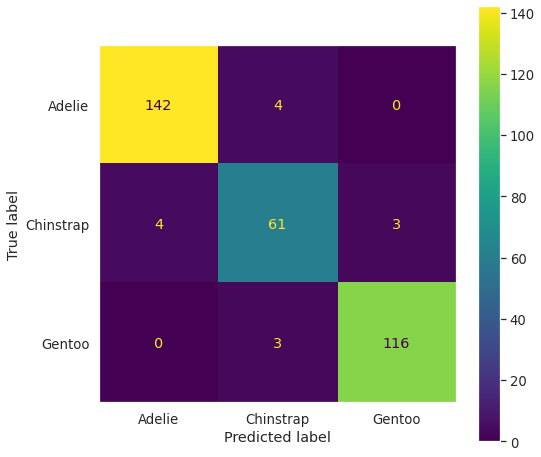

In [38]:
conf_mat_disp = ConfusionMatrixDisplay(conf_mat, display_labels=np.unique(y_true))
conf_mat_disp.plot()

plt.gcf().set_size_inches(8, 8)

# seaborn turns on grid by default ... looks best without it
plt.grid(False)

## In Class Exercise 2

Build a K-NN classifier which estimates whether a passenger on the titanic `survived` given their `age`, `pclass` and `fare` features.
- Discard any passengers which are missing a feature
- Be mindful of scale normalization, you may need to adjust data a bit
- Show the output of your classification as a confusion matrix plot, as shown above

In [39]:
import sklearn
sklearn.__version__

'1.1.0'

In [40]:
df_titanic = sns.load_dataset('titanic')
df_titanic.head()

survived  pclass     sex   age  sibsp  parch     fare embarked  class  \
0         0       3    male  22.0      1      0   7.2500        S  Third   
1         1       1  female  38.0      1      0  71.2833        C  First   
2         1       3  female  26.0      0      0   7.9250        S  Third   
3         1       1  female  35.0      1      0  53.1000        S  First   
4         0       3    male  35.0      0      0   8.0500        S  Third   

     who  adult_male deck  embark_town alive  alone  
0    man        True  NaN  Southampton    no  False  
1  woman       False    C    Cherbourg   yes  False  
2  woman       False  NaN  Southampton   yes   True  
3  woman       False    C  Southampton   yes  False  
4    man        True  NaN  Southampton    no   True

In [45]:
from sklearn.neighbors import KNeighborsClassifier
import pandas as pd

k = 5
x_feat_list = ['age', 'pclass', 'fare']
y_feat = 'survived'

df_titanic = sns.load_dataset('titanic')
df_titanic.dropna(how='any', inplace=True)

# scale normalization (overwrites old data)
for feat in x_feat_list:
    df_titanic[feat] = df_titanic[feat] / df_titanic[feat].std()

# extract data into numpy format (for sklearn)
x = df_titanic.loc[:, x_feat_list].values
y_true = df_titanic.loc[:, y_feat].values

# initialize a knn_classifier
knn_classifier = KNeighborsClassifier(n_neighbors=k)

# fit happens "inplace", we modify the internal state of knn_classifier to remember all the training samples
knn_classifier.fit(x, y_true)

# estimate each true y
y_pred = knn_classifier.predict(x)

ModuleNotFoundError: No module named 'sklearn'

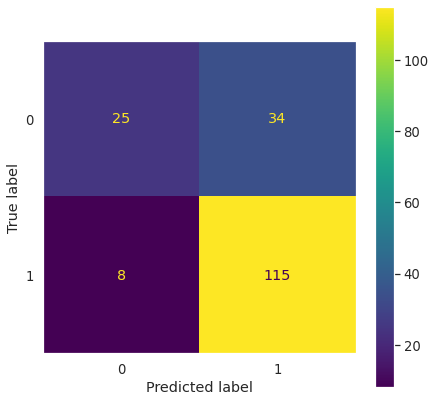

In [42]:
conf_mat = confusion_matrix(y_true=y_true, y_pred=y_pred)

conf_mat_disp = ConfusionMatrixDisplay(conf_mat, display_labels=np.unique(y_true))
conf_mat_disp.plot()

plt.gcf().set_size_inches(7, 7)

# seaborn turns on grid by default ... looks best without it
plt.grid(False)